## Image Classification 

### Convolutional Neural Network
#### Implimentation of Transfer learning and fine tuning


In [2]:
#!pip install h5py
#print("installed")

In [44]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


# transfer learning
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import h5py

# preprocess images
from tensorflow.keras.preprocessing import image


#metrics
from sklearn.metrics import confusion_matrix

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


import warnings

warnings.filterwarnings('ignore')

In [4]:
print(tf.__version__)

2.17.0


In [5]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape

(50000, 32, 32, 3)

In [6]:
labels = [
    'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
    'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
]

###  list 10 classes
Here are the 10 classes:

1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

In [7]:
# Combine train and test labels to get the entire dataset
y_all = np.concatenate([y_train, y_test])

In [8]:
# Count the number of elements in each category
unique, counts = np.unique(y_all, return_counts=True)
class_counts = dict(zip(unique, counts))
print(unique)
print(counts)
class_counts

[0 1 2 3 4 5 6 7 8 9]
[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


{0: 6000,
 1: 6000,
 2: 6000,
 3: 6000,
 4: 6000,
 5: 6000,
 6: 6000,
 7: 6000,
 8: 6000,
 9: 6000}

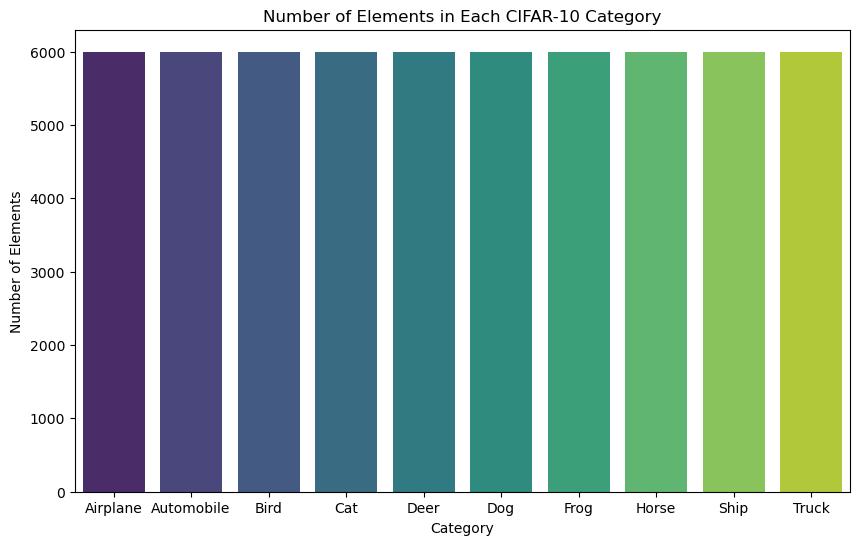

In [9]:
# Create a bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")

# Label the plot
plt.title('Number of Elements in Each CIFAR-10 Category')
plt.xlabel('Category')
plt.ylabel('Number of Elements')
plt.xticks(ticks=np.arange(10), labels=labels)

plt.show()

#### Balance Data
The data is balanced as there are 6000 accross each labels

In [10]:
# Split the Test set into test and validation set
# Split the original test set into validation and test sets (50% each)
x_val, x_test_new, y_val, y_test_new = train_test_split(x_test, y_test, test_size=0.5, random_state=42)


In [27]:
 #Display the shapes of the resulting sets ( Features and labels)
print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")
print(f"New Test set: {x_test_new.shape}, {y_test_new.shape}")

Training set: (50000, 32, 32, 3), (50000, 1)
Validation set: (5000, 32, 32, 3), (5000, 1)
New Test set: (5000, 32, 32, 3), (5000, 1)


### Data Generation


In [28]:
# Create a data generator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,          # Scaling pixel values
    rotation_range=5,          # Random rotation
    width_shift_range=0.05,      # Random horizontal shift
    height_shift_range=0.05,     # Random vertical shift
    shear_range=0.05,            # Shear transformation
    zoom_range=0.3,             # Random zoom
    horizontal_flip=True,       # Random horizontal flip
    fill_mode='nearest'         # Fill in missing pixels after augmentation
)

In [29]:
# Create data generators for validation and test (only scaling)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)


In [30]:
# Define batch size
batch_size = 32

In [31]:
# Creating the data generators
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = test_datagen.flow(x_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(x_test_new, y_test_new, batch_size=batch_size)



In [32]:
# Check the generators
print(train_generator, val_generator, test_generator)

<keras.src.legacy.preprocessing.image.NumpyArrayIterator object at 0x0000028D64A8D050> <keras.src.legacy.preprocessing.image.NumpyArrayIterator object at 0x0000028D6B661690> <keras.src.legacy.preprocessing.image.NumpyArrayIterator object at 0x0000028D642BB5D0>


### Modelling


In [57]:
# Initialize a Sequential model
model = models.Sequential()

In [58]:
# First Convolutional Block
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Second Convolutional Block
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Third Convolutional Block
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Third Convolutional Block
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Fourth Convolutional Block
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Flattening the 2D output to 1D
model.add(layers.Flatten())

# Fully Connected Layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Output Layer
model.add(layers.Dense(10, activation='softmax'))  # 10 classes for classification


In [59]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 581,002 (2.22 MB)

 Trainable params: 579,402 (2.21 MB)

 Non-trainable params: 1,600 (6.25 KB)

### Training the model


In [60]:
# Assuming you already have the train_generator, val_generator from earlier steps

# Train the model
history = model.fit(
    train_generator,
    epochs=10,  
    validation_data=val_generator
)

print('***********************************************************')
print('New Model Accuracy ')
# Record the final training accuracy
train_accuracy = history.history['accuracy'][-1]
print(f"Final training accuracy: {train_accuracy:.4f}")

# save the model before fine tuning
original_model = model


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 95s 57ms/step - accuracy: 0.2315 - loss: 2.3462 - val_accuracy: 0.4736 - val_loss: 1.4333
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 89s 57ms/step - accuracy: 0.4110 - loss: 1.6138 - val_accuracy: 0.5298 - val_loss: 1.2787
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 91s 58ms/step - accuracy: 0.4981 - loss: 1.4305 - val_accuracy: 0.5776 - val_loss: 1.1622
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 91s 58ms/step - accuracy: 0.5430 - loss: 1.3068 - val_accuracy: 0.6646 - val_loss: 0.9434
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 90s 58ms/step - accuracy: 0.5748 - loss: 1.2427 - val_accuracy: 0.6480 - val_loss: 0.9769
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 91s 58ms/step - accuracy: 0.6029 - loss: 1.1726 - val_accuracy: 0.6370 - val_loss: 1.0656
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 93s 59ms/step - accuracy: 0.6209 - loss: 1.1220 - val_accuracy: 0.6594 - val_loss: 0.9981
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 91s 58ms/step - accuracy: 0.6359 -

## Trying Different architectures (Added new layers) & other hyperparameters 

In [77]:
#Remove  Output layer
model.pop()
model.pop()
model.pop()
model.pop()
model.pop()
model.pop()
model.pop()
model.pop() # remove the output layer




model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 1, 1, 256)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,432 (2.05 MB)

 Trainable params: 537,216 (2.05 MB)

 Non-trainable params: 1,216 (4.75 KB)

## fINE tUNE THE MODEL

In [78]:
# Additional Convolutional Block
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

# Another Additional Convolutional Block
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

# Flatten the 2D output to 1D before fully connected layers
model.add(layers.Flatten())

# Fully Connected Layer 1
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Fully Connected Layer 2
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Fully Connected Layer 3
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Output Layer (10 classes)
model.add(layers.Dense(10, activation='softmax'))


In [79]:
## Compiling the model with additional layers
# change the optimiza
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 1, 1, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 1, 1, 512)      │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 4,257,418 (16.24 MB)

 Trainable params: 4,253,258 (16.22 MB)

 Non-trainable params: 4,160 (16.25 KB)

In [80]:
# Train the model with 20 epochs
history2 = model.fit(train_generator, epochs=15, validation_data=val_generator)


print('***********************************************************')
print('Fine Tuned Model Accuracy ')
# Record the final training accuracy
train_accuracy_2 = history2.history['accuracy'][-1]
print(f"Final training accuracy: {train_accuracy_2:.4f}")


Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 221s 138ms/step - accuracy: 0.5283 - loss: 1.5197 - val_accuracy: 0.7114 - val_loss: 0.8905
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 224s 143ms/step - accuracy: 0.6437 - loss: 1.1284 - val_accuracy: 0.7470 - val_loss: 0.7768
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 217s 138ms/step - accuracy: 0.6580 - loss: 1.0788 - val_accuracy: 0.7300 - val_loss: 0.8111
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 217s 139ms/step - accuracy: 0.6700 - loss: 1.0323 - val_accuracy: 0.7500 - val_loss: 0.7694
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 218s 139ms/step - accuracy: 0.6768 - loss: 1.0211 - val_accuracy: 0.7348 - val_loss: 0.7883
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 222s 142ms/step - accuracy: 0.6830 - loss: 0.9999 - val_accuracy: 0.6830 - val_loss: 0.9590
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 218s 139ms/step - accuracy: 0.6896 - loss: 0.9839 - val_accuracy: 0.7582 - val_loss: 0.7243
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 220s 141ms/step - ac

## Transfer Learning

We will use VGG16 as the base model for transfer learning. VGG16 is a well-established model known for its simplicity and effectiveness in image classification tasks. Its architecture has proven robust for various datasets, including CIFAR-10, even though it was originally trained on ImageNet, a dataset with more complex images.

The VGG16 model consists of multiple convolutional layers, followed by fully connected layers, which makes it ideal for feature extraction. By excluding the top layer (classification layer), we can adapt this model for CIFAR-10 by adding our custom classification head.

In [17]:

# Create the base model
# Load the VGG16 model with pretrained ImageNet weights, excluding the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model's layers so they aren't trained
base_model.trainable = False


In [18]:
# Create the New Model
pretrained_model = models.Sequential()

# add the base to the model
pretrained_model.add(base_model)



### Building on the Pretrained Model


In [19]:
# Add a flattening layer to convert 3D feature maps to 1D feature vectors
pretrained_model.add(layers.Flatten())

# Add a dense layer for classification with 64 units and ReLU activation
pretrained_model.add(layers.Dense(64, activation='relu'))
# Add a dropout layer for regularization
pretrained_model.add(layers.Dropout(0.5))

# Add the output layer with 10 units (for CIFAR-10 classes) and softmax activation
pretrained_model.add(layers.Dense(10, activation='softmax'))

# Compile the model
pretrained_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model
pretrained_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,748,170 (56.26 MB)

 Trainable params: 33,482 (130.79 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Preprocess_input in our model
The VGG16 model comes with a preprocess_input function, which normalizes the pixel values in the way that VGG16 expects based on how it was trained on ImageNet. 
This step is critical for proper transfer learning.

In [20]:
# Create data generators and apply preprocess_input for VGG16
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   rotation_range=5, 
                                   width_shift_range=0.05, 
                                   height_shift_range=0.05, 
                                   shear_range=0.05, 
                                   zoom_range=0.05, 
                                   horizontal_flip=True)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create the data generators
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
val_generator = val_test_datagen.flow(x_val, y_val, batch_size=32)
test_generator = val_test_datagen.flow(x_test_new, y_test_new, batch_size=32)

### Train the Pretrained Model

In [21]:
# Train the model using the train and validation data generators
pretrain_history = pretrained_model.fit(
    train_generator,
    epochs=10,  # You can experiment with more epochs
    validation_data=val_generator
)


print('***********************************************************')
print('Pretrained Model Accuracy ')
# Record the final training accuracy
pretrain_accuracy = pretrain_history.history['accuracy'][-1]
print(f"Final training accuracy: {pretrain_accuracy:.4f}")

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 307s 195ms/step - accuracy: 0.2311 - loss: 4.4446 - val_accuracy: 0.5080 - val_loss: 1.4340
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 313s 200ms/step - accuracy: 0.3898 - loss: 1.6956 - val_accuracy: 0.5472 - val_loss: 1.2794
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 308s 197ms/step - accuracy: 0.4540 - loss: 1.5246 - val_accuracy: 0.5950 - val_loss: 1.1885
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 298s 190ms/step - accuracy: 0.4853 - loss: 1.4388 - val_accuracy: 0.6118 - val_loss: 1.1510
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 297s 190ms/step - accuracy: 0.5056 - loss: 1.3906 - val_accuracy: 0.6264 - val_loss: 1.1177
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 306s 195ms/step - accuracy: 0.5230 - loss: 1.3621 - val_accuracy: 0.6286 - val_loss: 1.1107
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 300s 192ms/step - accuracy: 0.5298 - loss: 1.3470 - val_accuracy: 0.6224 - val_loss: 1.1170
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 308s 197ms/step - ac

### Experimenting with different architecture and freezing some layer


In [22]:
#Preserve the First Pretrained model
pretrained_original = pretrained_model


#Freeze some layers (Freeze all except the last two layers
for layer in base_model.layers[:-2]:
    layer.trainable = False


In [23]:
# remove the output layer 
pretrained_model.pop()
pretrained_model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,814,486 (56.51 MB)

 Trainable params: 32,832 (128.25 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 66,966 (261.59 KB)

In [24]:


# Add more dense layer for classification with 64 units and ReLU activation
pretrained_model.add(layers.Dense(64, activation='relu'))
# Add a dropout layer for regularization
pretrained_model.add(layers.Dropout(0.5))

# Add new top layers
pretrained_model.add(layers.Dense(256, activation='relu'))  
pretrained_model.add(layers.Dropout(0.5))  # Optionally add dropout for regularization


pretrained_model.add(layers.Dense(10, activation='softmax'))  # Output layer remains the same


pretrained_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

pretrained_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,770,890 (56.35 MB)

 Trainable params: 56,202 (219.54 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
finetune_history = pretrained_model.fit(train_generator, epochs=15, validation_data=val_generator)

print('***********************************************************')
print('Finetuned Pretrained Model Accuracy ')
# Record the final training accuracy
finetuned_pretrain_accuracy = finetune_history.history['accuracy'][-1]
print(f"Final training accuracy: {finetuned_pretrain_accuracy:.4f}")

Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 292s 186ms/step - accuracy: 0.3077 - loss: 2.7082 - val_accuracy: 0.6082 - val_loss: 1.2670
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 300s 192ms/step - accuracy: 0.4824 - loss: 1.6112 - val_accuracy: 0.6116 - val_loss: 1.2352
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 299s 191ms/step - accuracy: 0.5046 - loss: 1.5479 - val_accuracy: 0.6016 - val_loss: 1.2745
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5651s 4s/step - accuracy: 0.5051 - loss: 1.5648 - val_accuracy: 0.6018 - val_loss: 1.2546
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 269s 172ms/step - accuracy: 0.5001 - loss: 1.5594 - val_accuracy: 0.6186 - val_loss: 1.2312
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 288s 184ms/step - accuracy: 0.5093 - loss: 1.5504 - val_accuracy: 0.6326 - val_loss: 1.2193
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11333s 7s/step - accuracy: 0.5083 - loss: 1.5611 - val_accuracy: 0.6114 - val_loss: 1.2298
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 270s 172ms/step - accur

# Conclusion

In [81]:
print('********************* Different Model Accuracies *********************\n\n')
print('Non Pretrained CNN Model Accuracy ')

our_cnn_train_accuracy = history.history['accuracy'][-1]
our_cnn_val_accuracy = history.history['val_accuracy'][-1]
print(f"Our CNN training accuracy: {our_cnn_train_accuracy:.4f}")
print(f"Our CNN validation accuracy: {our_cnn_val_accuracy:.4f}")


print('***********************************************************\n\n')
print('Fine Tuned CNN Model Accuracy ')

our_finetuned_cnn_train_accuracy = history2.history['accuracy'][-1]
our_finetuned_cnn_val_accuracy = history2.history['val_accuracy'][-1]
print(f"Our Finetuned CNN training accuracy: {our_finetuned_cnn_train_accuracy:.4f}")
print(f"Our Finetuned CNN validation accuracy: {our_finetuned_cnn_val_accuracy:.4f}")



print('***********************************************************\n\n')
print('Base Model (VGG16)  Model Accuracy ')
# Record the final training accuracy
basemodel_train_accuracy = pretrain_history.history['accuracy'][-1]
basemodel_val_accuracy = pretrain_history.history['val_accuracy'][-1]
print(f"Final Base Model training  accuracy: {basemodel_train_accuracy:.4f}")
print(f"Final Base Model validation accuracy: {basemodel_val_accuracy:.4f}")



print('***********************************************************\n\n')
print('Base Model (VGG16) with fine tuning Model Accuracy ')
# Record the final training accuracy
finetune_basemodel_train_accuracy = finetune_history.history['accuracy'][-1]
finetune_basemodel_val_accuracy = finetune_history.history['val_accuracy'][-1]
print(f"Final Base Model training  accuracy: {finetune_basemodel_train_accuracy:.4f}")
print(f"Final Base Model validation accuracy: {finetune_basemodel_val_accuracy:.4f}")

********************* Different Model Accuracies *********************


Non Pretrained CNN Model Accuracy 
Our CNN training accuracy: 0.6556
Our CNN validation accuracy: 0.7378
***********************************************************


Fine Tuned CNN Model Accuracy 
Our Finetuned CNN training accuracy: 0.7110
Our Finetuned CNN validation accuracy: 0.7112
***********************************************************


Base Model (VGG16)  Model Accuracy 
Final Base Model training  accuracy: 0.5452
Final Base Model validation accuracy: 0.6322
***********************************************************


Base Model (VGG16) with fine tuning Model Accuracy 
Final Base Model training  accuracy: 0.4950
Final Base Model validation accuracy: 0.6176


## The Validation and Testing Predictions



In [82]:

# Get the testing data and labels
test_images, test_labels = next(iter(test_generator))  # or use your validation dataset directly

# Predict the classes
test_predictions_cnn = model.predict(test_images)
test_predicted_classes_cnn = np.argmax(test_predictions_cnn, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


In [83]:
# Confusion Matrix

# Get the validation data and labels
val_images, val_labels = next(iter(val_generator))  # or use your validation dataset directly

# Predict the classes
predictions_cnn = model.predict(val_images)
predicted_classes_cnn = np.argmax(predictions_cnn, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


### Best CNN Model Confusion Matrix on Validation set


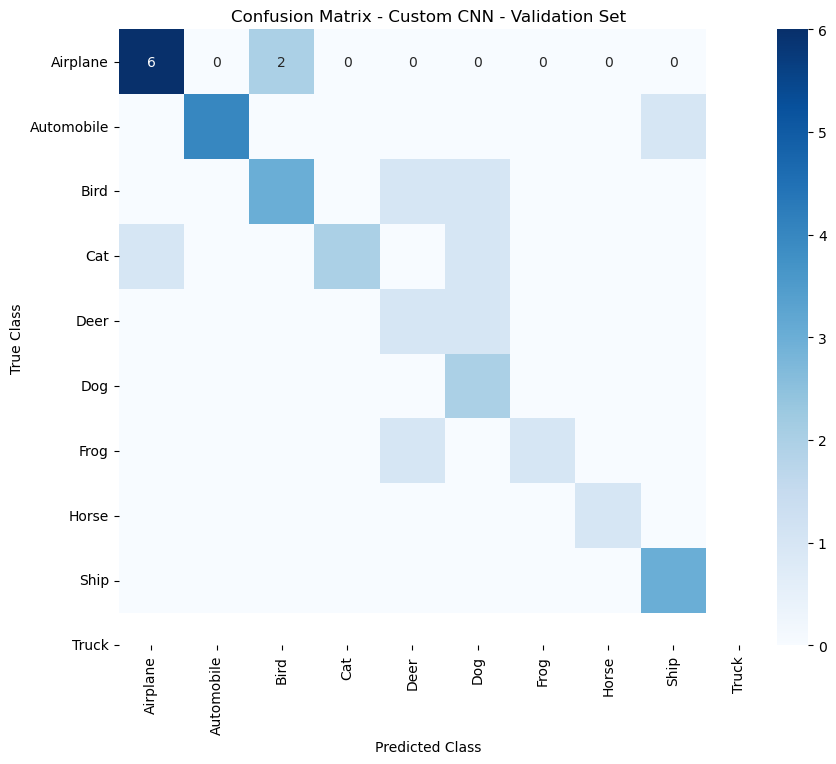

In [84]:

# Confusion matrix for our CNN with heightest accuracy
val_conf_matrix_cnn = confusion_matrix(val_labels, predicted_classes_cnn)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(val_conf_matrix_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Custom CNN - Validation Set")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


In [85]:
# Model accuracy on validation set
val_cnn_accuracy = model.evaluate(val_generator)
print("Our best CNN Model accuracy on Validation set: ",  val_cnn_accuracy)


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7213 - loss: 0.8538
Our best CNN Model accuracy on Validation set:  [0.8761382699012756, 0.7111999988555908]


### Best CNN Model Confusion Matrix on Testing set


### Best Pretrained Model Confusion Matrix on Validation set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


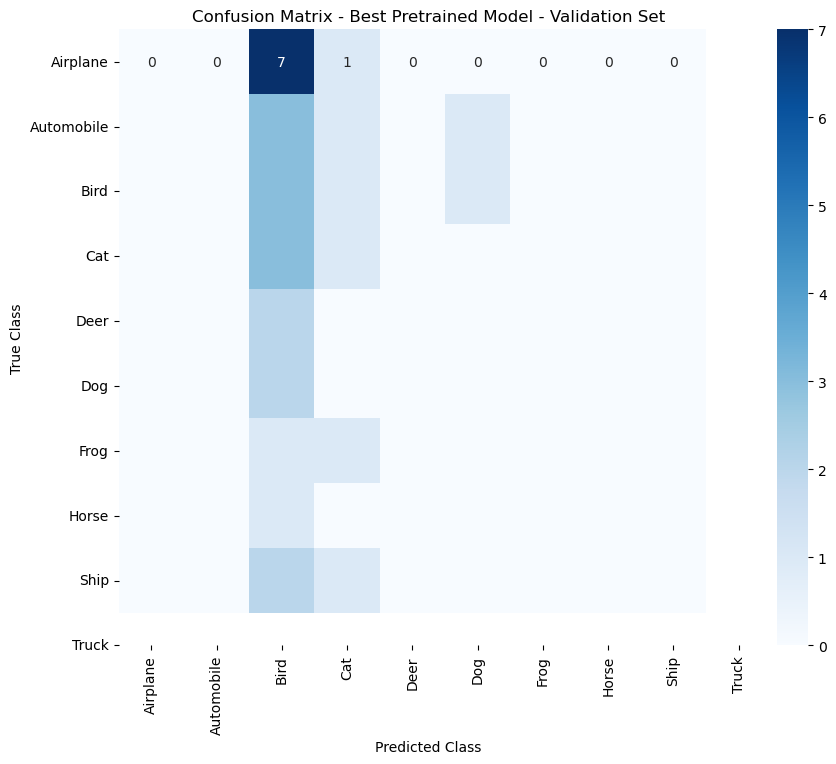

In [86]:
# Predict the classes for the validation set
predictions_transfer = pretrained_original.predict(val_images)
predicted_classes_transfer = np.argmax(predictions_transfer, axis=1)

# Confusion matrix
conf_matrix_transfer = confusion_matrix(val_labels, predicted_classes_transfer)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_transfer, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Best Pretrained Model - Validation Set")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [87]:
# Model accuracy on validation set
val_pretrained_cnn_accuracy = pretrained_original.evaluate(val_generator)
print("Our best Pre Trained Model accuracy on Validation set : ",  val_pretrained_cnn_accuracy)

157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.1054 - loss: 2.3268
Our best Pre Trained Model accuracy on Validation set :  [2.3236265182495117, 0.11240000277757645]


### Best Pretrained Model Confusion Matrix on Testing set

# Observation and Decision

Observations on the accuracies and comparing the two model (CNN and pretrained CNN) selecting the best model based on the model with the highest accuracy


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7210 - loss: 0.8473
Testing Accuracy For Best Model: 0.7200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


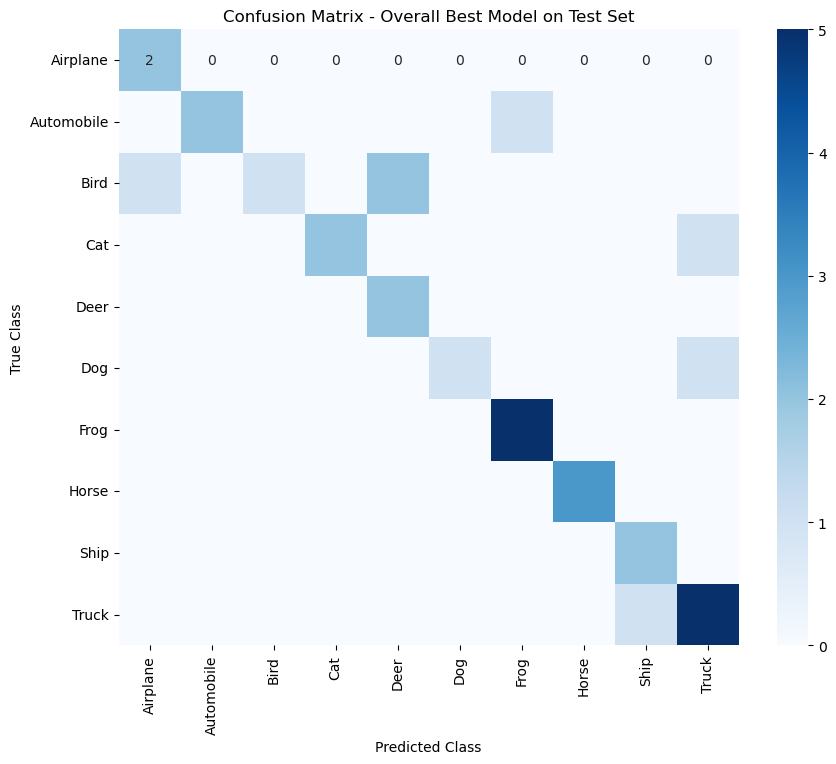

In [88]:
# Testing the best model (assuming transfer learning is the best model)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Testing Accuracy For Best Model: {test_accuracy:.4f}")

# Confusion matrix for test set
test_images, test_labels = next(iter(test_generator))  # or your test dataset directly
predictions_test = model.predict(test_images)
predicted_classes_test = np.argmax(predictions_test, axis=1)

conf_matrix_test = confusion_matrix(test_labels, predicted_classes_test)

# Plot confusion matrix for test set
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Overall Best Model on Test Set")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Use the model to make predictions on at least three other images from one of the 10 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
Predictions for images  1  is  Dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predictions for images  2  is  Frog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predictions for images  3  is  Truck


[5, 6, 9]

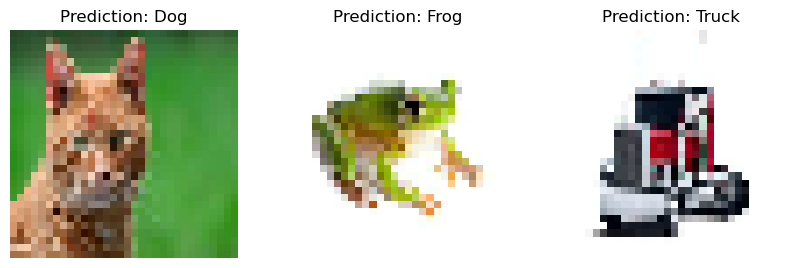

In [90]:
# Function to preprocess and make predictions on new images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(32, 32))
    img_array = image.img_to_array(img) / 255.0  # Scale image
    return np.expand_dims(img_array, axis=0), img  # return the preporcessed and original

# Paths to your new images (replace with actual paths)
image_paths = ['image1.jpeg', 'image2.jpeg', 'image3.jpeg']

plt.figure(figsize=(10, 5))  # Set up plot size

# Make predictions
predictions = []
i=0
for img_path in image_paths:
    i=i+1
    img, original_img = load_and_preprocess_image(img_path)
                                                 
    
    
    pred = model.predict(img)
    predicted_class = np.argmax(pred)
    print('Predictions for images ', i, ' is ', labels[predicted_class] )
    predictions.append(predicted_class)

    # Display image
    plt.subplot(1, len(image_paths), i)  # Adjust the subplot parameters according to the number of images
    plt.imshow(original_img)
    plt.title(f"Prediction: {labels[predicted_class]}")
    plt.axis('off')  # Hide axes

predictions  # This will output the predicted classes for the images



### Report
The Model Preformance is not very accurate as the accuracy is quite low for both the CNN and the PreTrained model as the predictions were not accurate. 

### Original Images)


![Image 1](image1.jpeg)
![Image 2](image2.jpeg)
![Image 3](image3.jpeg)